# Анализ данных для психо-диагностики в рамках танцевально-двигательной терапии

## Задачи:

* Предобработка данных
* Автоматизация дешифровки по ключу
* Подготовка графиков и данных для психологического исследования
* Проверка гипотез
* Кластеризация пользователей


In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import scipy.stats as stats
import datetime as dt
import seaborn as sns
from scipy import stats as st
from scipy.stats import wilcoxon
from scipy.cluster.hierarchy import dendrogram, linkage


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans


%config InlineBackend.figure_format='retina'
%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

In [2]:
sit_trev = pd.read_csv(r'C:\Users\Иванов\sit_trev.csv', sep=';')

In [3]:
sit_trev.head()

,Подразделение,Ваш возраст,Семейное положение,Есть ли у вас дети?,Какой у вас стаж работы вахтой?,Я спокоен,Мне ничто не угрожает,Я нахожусь в напряжении,Я испытываю сожаление,Я чувствую себя свободно,Я расстроен,Меня волнуют возможные неудачи,Я чувствую себя отдохнувшим,Я не доволен собой,Я испытываю чувство внутреннего удовлетворения,Я уверен в себе,Я нервничаю,Я не нахожу себе места,Я взвинчен,"Я не чувствую скованности, напряженности",Я доволен,Я озабочен,"Я слишком возбужден, и мне не по себе",Мне радостно,Мне приятно,Я испытываю удовольствие,Я очень быстро устаю,Я легко могу заплакать,"Я хотел бы быть таким же счастливым, как и другие","Нередко я проигрываю из-за того, что недостаточно быстро принимаю решения",Обычно я чувствую себя бодрым,"Я спокоен, хладнокровен и собран",Ожидаемые трудности обычно очень тревожат меня,Я слишком переживаю из-за пустяков,Я вполне счастлив,Я принимаю все слишком близко к сердцу,Мне не хватает уверенности в себе,Обычно я чувствую себя в безопасности,Я стараюсь избегать критических ситуаций,У меня бывает хандра,Я доволен,Всякие пустяки отвлекают и волнуют меня,"Я так сильно переживаю свои разочарования, что потом долго не могу о них забыть",Я уравновешенный человек,"Меня охватывает сильное беспокойство, когда я думаю о своих делах и заботах"
0,СМУ-1,33,замужем,нет детей,0,Верно,Совершенно верно,"Пожалуй, так",1,Верно,"Пожалуй, так","Пожалуй, так",1,1,Верно,1,Верно,1,1,"Пожалуй, так",Верно,Совершенно верно,1,"Пожалуй, так","Пожалуй, так","Пожалуй, так",1,"Пожалуй, так","Пожалуй, так",1,Верно,"Пожалуй, так","Пожалуй, так",1,Верно,"Нет, это не так","Пожалуй, так",Совершенно верно,"Пожалуй, так",Верно,Совершенно верно,"Нет, это не так","Нет, это не так",Верно,Верно
1,СМУ-1,45,не замужем,есть дети,5,"Пожалуй, так",Верно,"Пожалуй, так",1,"Пожалуй, так",1,"Пожалуй, так",1,1,"Пожалуй, так",Верно,"Пожалуй, так",1,1,"Пожалуй, так","Пожалуй, так",1,1,"Пожалуй, так","Пожалуй, так","Пожалуй, так",Верно,Верно,Совершенно верно,Верно,"Пожалуй, так","Пожалуй, так","Пожалуй, так",Верно,1,"Пожалуй, так","Пожалуй, так","Нет, это не так",Верно,Верно,"Пожалуй, так",Верно,"Пожалуй, так","Пожалуй, так",Верно
2,СМУ-1,25,не замужем,нет детей,2,1,"Пожалуй, так",Верно,1,1,1,"Пожалуй, так",1,1,"Пожалуй, так","Пожалуй, так",Верно,1,"Пожалуй, так",1,1,"Пожалуй, так",1,1,1,1,1,"Пожалуй, так",Верно,1,"Пожалуй, так",1,Верно,"Пожалуй, так","Пожалуй, так","Пожалуй, так","Нет, это не так","Пожалуй, так",Верно,Верно,"Пожалуй, так","Пожалуй, так","Пожалуй, так","Пожалуй, так","Пожалуй, так"
3,СМУ-2,35,не замужем,нет детей,2,"Пожалуй, так",Верно,Верно,"Пожалуй, так",1,1,Верно,1,"Пожалуй, так",1,Верно,1,1,"Пожалуй, так",1,1,"Пожалуй, так",1,1,1,"Пожалуй, так","Пожалуй, так",1,Верно,Верно,Верно,Верно,Совершенно верно,Совершенно верно,1,Верно,Верно,"Пожалуй, так",Совершенно верно,Верно,"Пожалуй, так",Верно,"Пожалуй, так",Совершенно верно,"Нет, это не так"
4,СМУ-2,49,замужем,есть дети,4,1,"Пожалуй, так","Пожалуй, так",Верно,1,Верно,"Пожалуй, так",1,"Пожалуй, так",1,1,"Пожалуй, так","Пожалуй, так","Пожалуй, так",1,1,"Пожалуй, так","Пожалуй, так",1,1,1,Верно,"Пожалуй, так",Верно,1,1,1,"Пожалуй, так",Верно,1,Верно,Верно,"Пожалуй, так","Пожалуй, так",Верно,"Нет, это не так",Верно,Верно,"Нет, это не так",Верно


### Предобработка данных (таблица тревожность)

In [4]:
sit_trev = sit_trev.replace('Совершенно верно', 4)
sit_trev = sit_trev.replace('Верно', 3)
sit_trev = sit_trev.replace('Пожалуй, так', 2)
sit_trev = sit_trev.replace('Нет, это не так', 1)
sit_trev = sit_trev.replace('4', 4)
sit_trev = sit_trev.replace('3', 3)
sit_trev = sit_trev.replace('2', 2)
sit_trev = sit_trev.replace('1', 1)
sit_trev['Какой у вас стаж работы вахтой?'] = sit_trev['Какой у вас стаж работы вахтой?'].replace('Менее года', 0)


### Расчет баллов (дешифровка по ключу)

СТ = Σ 1 - Σ 2 + 35,
где 

Σ 1 - сумма зачеркнутых цифр на бланке по пунктам шкалы 3, 4, 6, 7, 9, 12, 13, 14, 17, 18;

Σ 2 - сумма остальных зачеркнутых цифр по пунктам 1, 2, 5, 8, 10, 11, 15, 16, 19, 20

In [5]:
st_sum_1 = sit_trev['Я нахожусь в напряжении']+sit_trev['Я испытываю сожаление']+sit_trev['Я расстроен']+sit_trev['Меня волнуют возможные неудачи']+sit_trev['Я не доволен собой']+sit_trev['Я нервничаю']+sit_trev['Я не нахожу себе места']+sit_trev['Я взвинчен']+sit_trev['Я озабочен']+sit_trev['Я слишком возбужден, и мне не по себе']

In [6]:
st_sum_2 = sit_trev['Я спокоен']+sit_trev['Мне ничто не угрожает']+sit_trev['Я чувствую себя свободно']+sit_trev['Я чувствую себя отдохнувшим']+sit_trev['Я испытываю чувство внутреннего удовлетворения']+sit_trev['Я уверен в себе']+sit_trev['Я не чувствую скованности, напряженности']+sit_trev['Я доволен']+sit_trev['Мне радостно']+sit_trev['Мне приятно']

In [7]:
sit_trev['st'] = st_sum_1 - st_sum_2 + 35

ЛТ = Σ 1 - Σ 2 + 35,
где Σ 1 - сумма зачеркнутых цифр на бланке по пунктам шкалы 22, 23, 24, 25, 28, 29, 31, 32, 34, 35, 37, 38, 40;

Σ 2 - сумма остальных зачеркнутых цифр по пунктам 21, 26, 27, 30, 33, 36, 39.

In [8]:
lt_sum_1 = sit_trev['Я очень быстро устаю ']+sit_trev['Я легко могу заплакать ']+sit_trev['Я хотел бы быть таким же счастливым, как и другие '] + sit_trev['Нередко я проигрываю из-за того, что недостаточно быстро принимаю решения '] + sit_trev['Ожидаемые трудности обычно очень тревожат меня '] + sit_trev['Я слишком переживаю из-за пустяков '] + sit_trev['Я принимаю все слишком близко к сердцу '] + sit_trev['Мне не хватает уверенности в себе'] + sit_trev['Я стараюсь избегать критических ситуаций '] + sit_trev['У меня бывает хандра '] + sit_trev['Всякие пустяки отвлекают и волнуют меня '] + sit_trev['Я так сильно переживаю свои разочарования, что потом долго не могу о них забыть '] + sit_trev['Меня охватывает сильное беспокойство, когда я думаю о своих делах и заботах ']

In [9]:
lt_sum_2 = sit_trev['Я испытываю удовольствие '] + sit_trev['Обычно я чувствую себя бодрым '] + sit_trev['Я спокоен, хладнокровен и собран '] + sit_trev['Я вполне счастлив '] + sit_trev['Обычно я чувствую себя в безопасности '] + sit_trev['Я доволен '] + sit_trev['Я уравновешенный человек ']

In [10]:
sit_trev['lt'] = lt_sum_1 - lt_sum_2 + 35

In [11]:
sit_trev.head()

,Подразделение,Ваш возраст,Семейное положение,Есть ли у вас дети?,Какой у вас стаж работы вахтой?,Я спокоен,Мне ничто не угрожает,Я нахожусь в напряжении,Я испытываю сожаление,Я чувствую себя свободно,Я расстроен,Меня волнуют возможные неудачи,Я чувствую себя отдохнувшим,Я не доволен собой,Я испытываю чувство внутреннего удовлетворения,Я уверен в себе,Я нервничаю,Я не нахожу себе места,Я взвинчен,"Я не чувствую скованности, напряженности",Я доволен,Я озабочен,"Я слишком возбужден, и мне не по себе",Мне радостно,Мне приятно,Я испытываю удовольствие,Я очень быстро устаю,Я легко могу заплакать,"Я хотел бы быть таким же счастливым, как и другие","Нередко я проигрываю из-за того, что недостаточно быстро принимаю решения",Обычно я чувствую себя бодрым,"Я спокоен, хладнокровен и собран",Ожидаемые трудности обычно очень тревожат меня,Я слишком переживаю из-за пустяков,Я вполне счастлив,Я принимаю все слишком близко к сердцу,Мне не хватает уверенности в себе,Обычно я чувствую себя в безопасности,Я стараюсь избегать критических ситуаций,У меня бывает хандра,Я доволен,Всякие пустяки отвлекают и волнуют меня,"Я так сильно переживаю свои разочарования, что потом долго не могу о них забыть",Я уравновешенный человек,"Меня охватывает сильное беспокойство, когда я думаю о своих делах и заботах",st,lt
0,СМУ-1,33,замужем,нет детей,0,3,4,2,1,3,2,2,1,1,3,1,3,1,1,2,3,4,1,2,2,2,1,2,2,1,3,2,2,1,3,1,2,4,2,3,4,1,1,3,3,29,36
1,СМУ-1,45,не замужем,есть дети,5,2,3,2,1,2,1,2,1,1,2,3,2,1,1,2,2,1,1,2,2,2,3,3,4,3,2,2,2,3,1,2,2,1,3,3,2,3,2,2,3,27,59
2,СМУ-1,25,не замужем,нет детей,2,1,2,3,1,1,1,2,1,1,2,2,3,1,2,1,1,2,1,1,1,1,1,2,3,1,2,1,3,2,2,2,1,2,3,3,2,2,2,2,2,39,50
3,СМУ-2,35,не замужем,нет детей,2,2,3,3,2,1,1,3,1,2,1,3,1,1,2,1,1,2,1,1,1,2,2,1,3,3,3,3,4,4,1,3,3,2,4,3,2,3,2,4,1,38,54
4,СМУ-2,49,замужем,есть дети,4,1,2,2,3,1,3,2,1,2,1,1,2,2,2,1,1,2,2,1,1,1,3,2,3,1,1,1,2,3,1,3,3,2,2,3,1,3,3,1,3,46,61


### Выделение групп

In [12]:
def age_group(age):
    if age < 35:
        return '25-34'
    if 35 <= age <= 44:
        return '35-44'
    return '45-54'
sit_trev['age_group'] = sit_trev['Ваш возраст'].apply(age_group)

In [13]:
def experience_group(experience):
    if experience >= 3:
        return 'больше 3-х лет'
    return 'до 3-х лет'
sit_trev['experience_group'] = sit_trev['Какой у вас стаж работы вахтой?'].apply(experience_group)

In [14]:
def group_t(t):
    if t < 30:
        return 'низкая'
    if 31 <= t <= 45:
        return 'средняя'
    return 'высокая'
sit_trev['group_st'] = sit_trev['st'].apply(group_t)
sit_trev['group_lt'] = sit_trev['lt'].apply(group_t)

In [15]:
sit_trev.head()

,Подразделение,Ваш возраст,Семейное положение,Есть ли у вас дети?,Какой у вас стаж работы вахтой?,Я спокоен,Мне ничто не угрожает,Я нахожусь в напряжении,Я испытываю сожаление,Я чувствую себя свободно,Я расстроен,Меня волнуют возможные неудачи,Я чувствую себя отдохнувшим,Я не доволен собой,Я испытываю чувство внутреннего удовлетворения,Я уверен в себе,Я нервничаю,Я не нахожу себе места,Я взвинчен,"Я не чувствую скованности, напряженности",Я доволен,Я озабочен,"Я слишком возбужден, и мне не по себе",Мне радостно,Мне приятно,Я испытываю удовольствие,Я очень быстро устаю,Я легко могу заплакать,"Я хотел бы быть таким же счастливым, как и другие","Нередко я проигрываю из-за того, что недостаточно быстро принимаю решения",Обычно я чувствую себя бодрым,"Я спокоен, хладнокровен и собран",Ожидаемые трудности обычно очень тревожат меня,Я слишком переживаю из-за пустяков,Я вполне счастлив,Я принимаю все слишком близко к сердцу,Мне не хватает уверенности в себе,Обычно я чувствую себя в безопасности,Я стараюсь избегать критических ситуаций,У меня бывает хандра,Я доволен,Всякие пустяки отвлекают и волнуют меня,"Я так сильно переживаю свои разочарования, что потом долго не могу о них забыть",Я уравновешенный человек,"Меня охватывает сильное беспокойство, когда я думаю о своих делах и заботах",st,lt,age_group,experience_group,group_st,group_lt
0,СМУ-1,33,замужем,нет детей,0,3,4,2,1,3,2,2,1,1,3,1,3,1,1,2,3,4,1,2,2,2,1,2,2,1,3,2,2,1,3,1,2,4,2,3,4,1,1,3,3,29,36,25-34,до 3-х лет,низкая,средняя
1,СМУ-1,45,не замужем,есть дети,5,2,3,2,1,2,1,2,1,1,2,3,2,1,1,2,2,1,1,2,2,2,3,3,4,3,2,2,2,3,1,2,2,1,3,3,2,3,2,2,3,27,59,45-54,больше 3-х лет,низкая,высокая
2,СМУ-1,25,не замужем,нет детей,2,1,2,3,1,1,1,2,1,1,2,2,3,1,2,1,1,2,1,1,1,1,1,2,3,1,2,1,3,2,2,2,1,2,3,3,2,2,2,2,2,39,50,25-34,до 3-х лет,средняя,высокая
3,СМУ-2,35,не замужем,нет детей,2,2,3,3,2,1,1,3,1,2,1,3,1,1,2,1,1,2,1,1,1,2,2,1,3,3,3,3,4,4,1,3,3,2,4,3,2,3,2,4,1,38,54,35-44,до 3-х лет,средняя,высокая
4,СМУ-2,49,замужем,есть дети,4,1,2,2,3,1,3,2,1,2,1,1,2,2,2,1,1,2,2,1,1,1,3,2,3,1,1,1,2,3,1,3,3,2,2,3,1,3,3,1,3,46,61,45-54,больше 3-х лет,высокая,высокая


### распределение по группам

In [16]:
sit_trev['group_st'].value_counts()

низкая     16
средняя    15
высокая     9
Name: group_st, dtype: int64

In [17]:
sit_trev['group_lt'].value_counts()

высокая    20
средняя    19
низкая      1
Name: group_lt, dtype: int64

### графики и данные для исследования

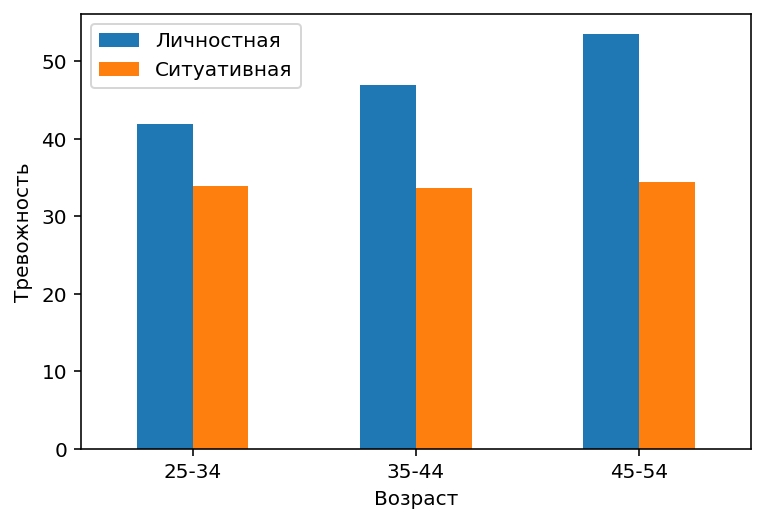

In [18]:
sit_trev_pivot_age = sit_trev.pivot_table(index=['age_group'], values=['st','lt'], aggfunc=['mean'])
sit_trev_pivot_age.columns =['Личностная','Ситуативная']
sit_trev_pivot_age.plot.bar(rot=0)
plt.xlabel("Возраст")
plt.ylabel("Тревожность")
plt.show()

In [19]:
sit_trev_pivot_age

,Личностная,Ситуативная
age_group,,
25-34,41.846154,33.846154
35-44,46.944444,33.666667
45-54,53.444444,34.444444


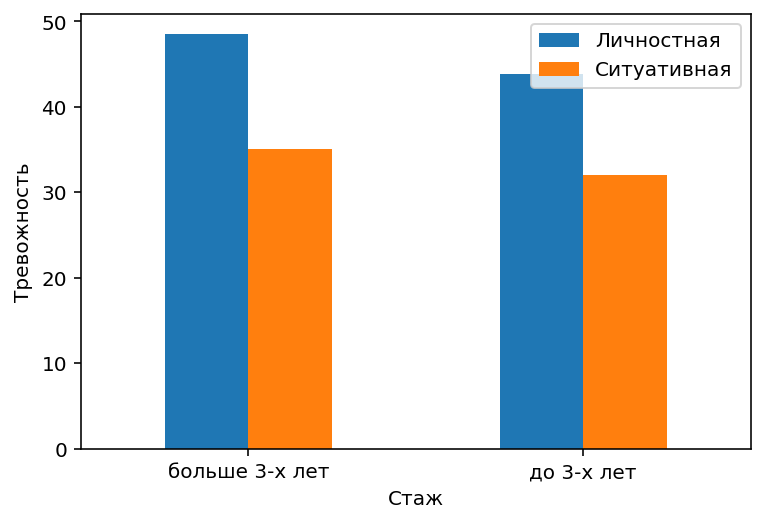

In [20]:
sit_trev_pivot_experience = sit_trev.pivot_table(index=['experience_group'], values=['st','lt'], aggfunc=['mean'])
sit_trev_pivot_experience.columns =['Личностная','Ситуативная']
sit_trev_pivot_experience.plot.bar(rot=0)
plt.xlabel("Стаж")
plt.ylabel("Тревожность")
plt.show()

In [21]:
sit_trev_pivot_experience

,Личностная,Ситуативная
experience_group,,
больше 3-х лет,48.480000,35.04
до 3-х лет,43.866667,32.00


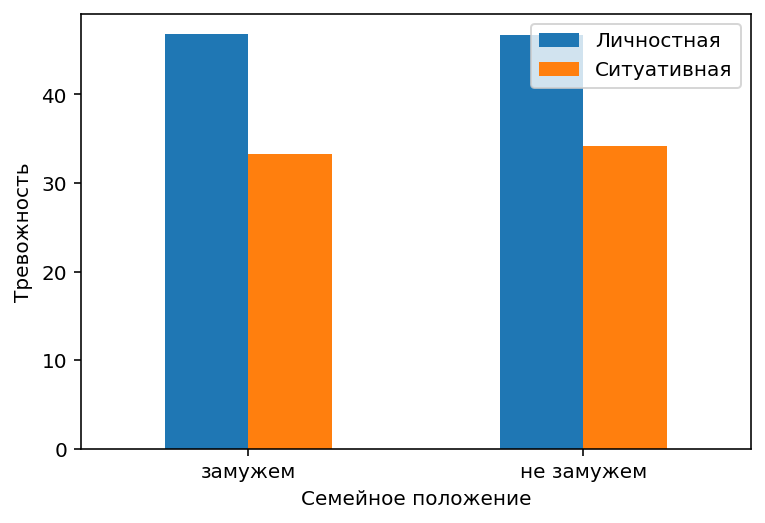

In [22]:
sit_trev_pivot_married = sit_trev.pivot_table(index=['Семейное положение'], values=['st','lt'], aggfunc=['mean'])
sit_trev_pivot_married.columns =['Личностная','Ситуативная']
sit_trev_pivot_married.plot.bar(rot=0)
plt.xlabel("Семейное положение")
plt.ylabel("Тревожность")
plt.show()

In [23]:
sit_trev_pivot_married

,Личностная,Ситуативная
Семейное положение,,
замужем,46.785714,33.285714
не замужем,46.730769,34.230769


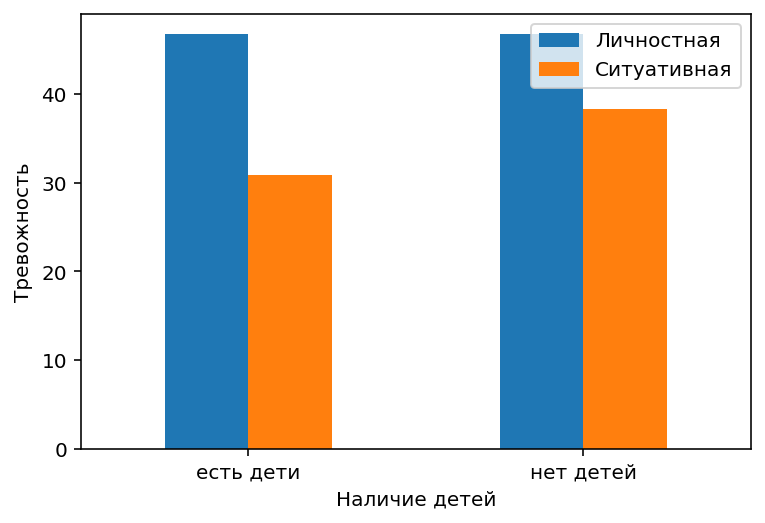

In [24]:
sit_trev_pivot_children = sit_trev.pivot_table(index=['Есть ли у вас дети?'], values=['st','lt'], aggfunc=['mean'])
sit_trev_pivot_children.columns =['Личностная','Ситуативная']
sit_trev_pivot_children.plot.bar(rot=0)
plt.xlabel("Наличие детей")
plt.ylabel("Тревожность")
plt.show()

In [25]:
sit_trev_pivot_children

,Личностная,Ситуативная
Есть ли у вас дети?,,
есть дети,46.75,30.916667
нет детей,46.75,38.375000


## САН

In [26]:
df_2 = pd.read_csv(r'C:\Users\Иванов\df_2.csv', sep=';')

In [27]:
df_2['age_group'] = df_2['Ваш возраст'].apply(age_group)

In [28]:
df_2['experience_group'] = df_2['Какой у вас стаж работы вахтой?'].apply(experience_group)

In [29]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Должность                        40 non-null     object 
 1   Ваш возраст                      40 non-null     int64  
 2   Семейное положение               40 non-null     object 
 3   Есть ли у вас дети?              40 non-null     object 
 4   Какой у вас стаж работы вахтой?  40 non-null     int64  
 5   Настроение                       40 non-null     float64
 6   Активность                       40 non-null     float64
 7   Самочувствие                     40 non-null     float64
 8   age_group                        40 non-null     object 
 9   experience_group                 40 non-null     object 
dtypes: float64(3), int64(2), object(5)
memory usage: 3.2+ KB


In [30]:
df_2.describe()

,Ваш возраст,Какой у вас стаж работы вахтой?,Настроение,Активность,Самочувствие
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,38.350000,3.400000,4.292500,4.320000,4.290000
std,7.371289,2.570044,1.495015,1.183476,1.499367
min,25.000000,0.000000,1.000000,1.000000,1.000000
25%,33.000000,1.750000,3.700000,3.575000,3.675000
50%,38.500000,3.000000,4.400000,4.350000,4.200000
75%,42.500000,5.000000,5.250000,5.125000,5.125000
max,56.000000,10.000000,6.900000,6.500000,6.700000


In [31]:
df_2_pivot_age = df_2.pivot_table(index=['age_group'], values=['Настроение','Активность','Самочувствие'], aggfunc=['mean'])

In [32]:
df_2_pivot_age.columns =['Активность', 'Настроение', 'Самочувствие']

### графики и данные для исследования

In [33]:
df_2_pivot_age

,Активность,Настроение,Самочувствие
age_group,,,
25-34,4.123077,3.953846,4.069231
35-44,4.450000,4.733333,4.716667
45-54,4.344444,3.900000,3.755556


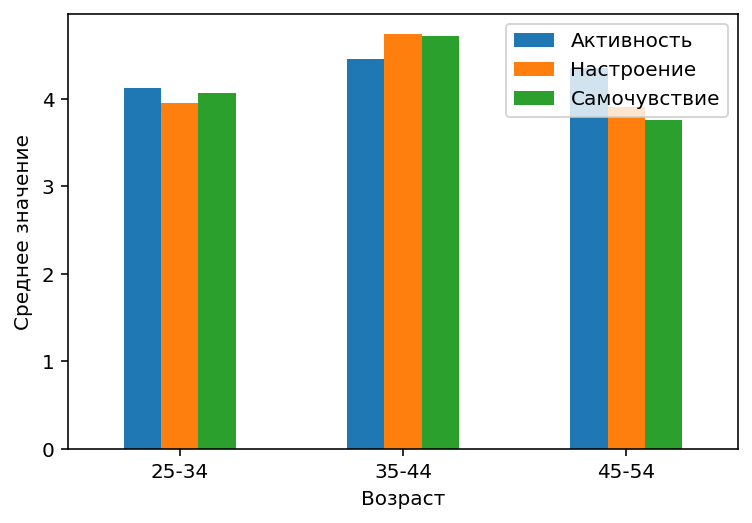

In [34]:
df_2_pivot_age.plot.bar(rot=0)
plt.xlabel("Возраст")
plt.ylabel("Среднее значение")
plt.show()

In [35]:
df_2_pivot_experience = df_2.pivot_table(index=['experience_group'], values=['Настроение','Активность','Самочувствие'], aggfunc=['mean'])
df_2_pivot_experience.columns =['Активность', 'Настроение', 'Самочувствие']
df_2_pivot_experience

,Активность,Настроение,Самочувствие
experience_group,,,
больше 3-х лет,4.220000,4.128000,4.068
до 3-х лет,4.486667,4.566667,4.660


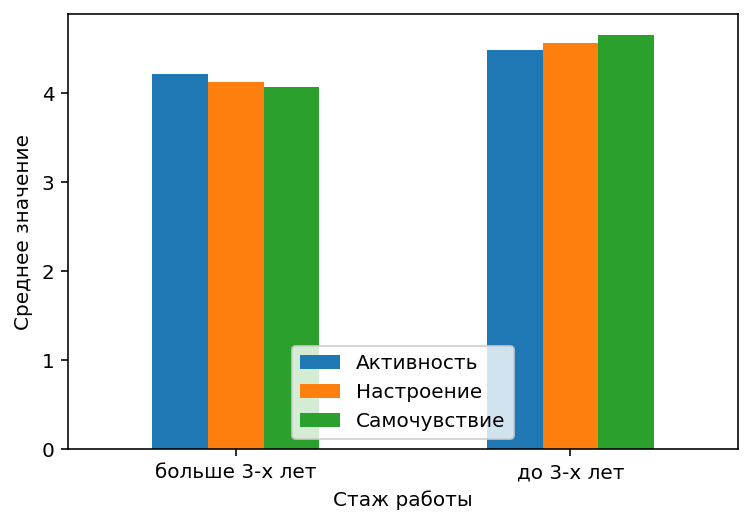

In [36]:
df_2_pivot_experience.plot.bar(rot=0)
plt.xlabel("Стаж работы")
plt.ylabel("Среднее значение")
plt.show()

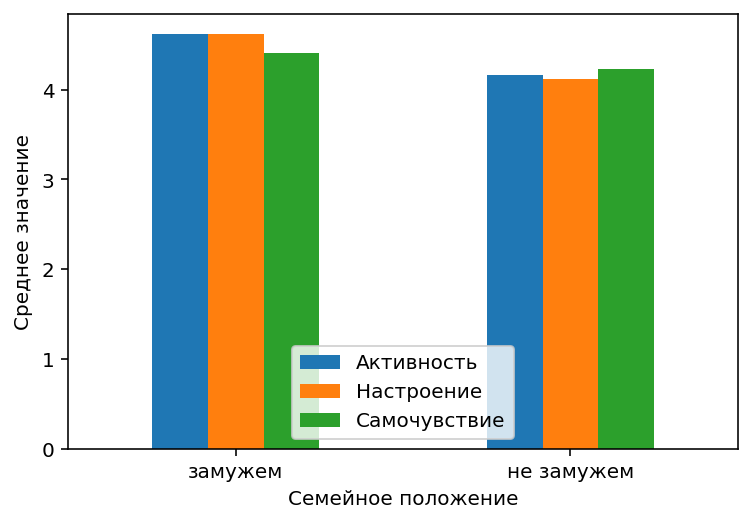

In [37]:
df_2_pivot_married = df_2.pivot_table(index=['Семейное положение'], values=['Настроение','Активность','Самочувствие'], aggfunc=['mean'])
df_2_pivot_married.columns =['Активность', 'Настроение', 'Самочувствие']
df_2_pivot_married.plot.bar(rot=0)
plt.xlabel("Семейное положение")
plt.ylabel("Среднее значение")
plt.show()

In [38]:
df_2_pivot_married

,Активность,Настроение,Самочувствие
Семейное положение,,,
замужем,4.614286,4.614286,4.407143
не замужем,4.161538,4.119231,4.226923


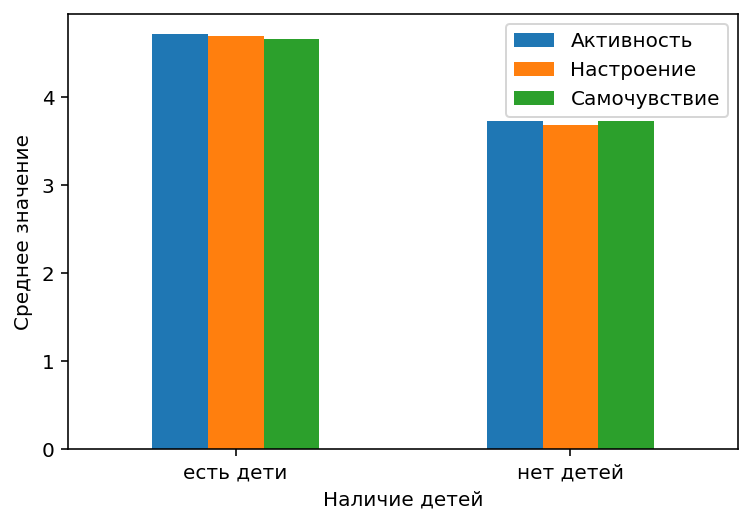

In [39]:
df_2_pivot_children = df_2.pivot_table(index=['Есть ли у вас дети?'], values=['Настроение','Активность','Самочувствие'], aggfunc=['mean'])
df_2_pivot_children.columns =['Активность', 'Настроение', 'Самочувствие']
df_2_pivot_children.plot.bar(rot=0)
plt.xlabel("Наличие детей")
plt.ylabel("Среднее значение")
plt.show()

In [40]:
df_2_pivot_children

,Активность,Настроение,Самочувствие
Есть ли у вас дети?,,,
есть дети,4.71250,4.70000,4.66250
нет детей,3.73125,3.68125,3.73125


## А/В-тесты

### Подготовка данных

In [41]:
sit_next = pd.read_csv(r'C:\Users\Иванов\sit_trev_3.csv', sep=';')

In [42]:
san_next = pd.read_csv(r'C:\Users\Иванов\df_3.csv', sep=';')

In [43]:
sit_next

,Подразделение,Ваш возраст,Семейное положение,Есть ли у вас дети?,Какой у вас стаж работы вахтой?,СТ до ТДТ,СТ после ТДТ,ЛТ до ТДТ,ЛТ после ТДТ
0,Э,38,не замужем,есть дети,8,38,32,54,52
1,Э,42,не замужем,есть дети,2,18,15,38,37
2,Э,39,замужем,есть дети,0,29,25,39,26
3,Э,29,не замужем,есть дети,4,21,19,33,30
4,Э,47,замужем,есть дети,2,38,36,54,53
5,Э,27,не замужем,нет детей,1,60,50,67,64
6,Э,32,не замужем,нет детей,3,37,33,46,45
7,Э,55,замужем,есть дети,3,19,19,27,27


In [44]:
san_next

,Должность,Ваш возраст,Семейное положение,Есть ли у вас дети?,Какой у вас стаж работы вахтой?,Настроение до ТДТ,Настроение после ТДТ,Активность до ТДТ,Активность после ТДТ,Самочувствие до ТДТ,Самочувствие после ТДТ
0,Э,38,не замужем,есть дети,8,5.0,5.5,5.1,5.2,5.0,6.0
1,Э,42,не замужем,есть дети,2,6.2,6.0,5.5,5.4,5.8,6.1
2,Э,39,замужем,есть дети,0,5.8,6.1,5.2,5.1,5.7,6.0
3,Э,29,не замужем,есть дети,4,4.6,5.1,6.4,6.5,5.8,6.1
4,Э,47,замужем,есть дети,2,5.0,5.5,5.1,4.9,5.0,5.5
5,Э,27,не замужем,нет детей,1,1.0,3.2,1.8,2.2,1.5,2.9
6,Э,32,не замужем,нет детей,3,2.6,3.2,3.6,3.8,2.6,3.1
7,Э,55,замужем,есть дети,3,6.9,6.7,6.5,6.2,6.5,6.1


### Проверка гипотез

Выборки связные, малые. Количество участников одинаковое.

Применяем критерий Уилкоксона.

Уровень статистической значимости определяем равным 0.05

Нулевая гипотеза: различий в настроении до танцевально-двигательной терапии и после нет.

Альтернативная гипотеза: различия в настроении до танцевально-двигательной терапии и после есть.

In [45]:
old_n = san_next['Настроение до ТДТ']
new_n = san_next['Настроение после ТДТ']

alpha = 0.05  # критический уровень статистической значимости

results = wilcoxon(old_n, new_n)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.0390625
Отвергаем нулевую гипотезу: разница статистически значима


Нулевая гипотеза: различий в активности до танцевально-двигательной терапии и после нет.

Альтернативная гипотеза: различия в активности до танцевально-двигательной терапии и после есть.

In [46]:
old_a = san_next['Активность до ТДТ']
new_a = san_next['Активность после ТДТ']

alpha = 0.05  # критический уровень статистической значимости

results = wilcoxon(old_a, new_a)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.9453125
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Нулевая гипотеза: различий в самочувствии до танцевально-двигательной терапии и после нет.

Альтернативная гипотеза: различия в самочувствии до танцевально-двигательной терапии и после есть.

In [47]:
old_s = san_next['Самочувствие до ТДТ']
new_s = san_next['Самочувствие после ТДТ']

alpha = 0.05  # критический уровень статистической значимости

results = wilcoxon(old_s, new_s)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.0546875
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Нулевая гипотеза: различий в ситуативной тревожности до танцевально-двигательной терапии и после нет.

Альтернативная гипотеза: различия в ситуативной тревожности до танцевально-двигательной терапии и после есть.

In [48]:
old_st = sit_next['СТ до ТДТ']
new_st = sit_next['СТ после ТДТ']

alpha = 0.05  # критический уровень статистической значимости

results = wilcoxon(old_st, new_st)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.01755232593841686
Отвергаем нулевую гипотезу: разница статистически значима


C:\anaconda3\envs\da_practicum_env\lib\site-packages\scipy\stats\_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\anaconda3\envs\da_practicum_env\lib\site-packages\scipy\stats\_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Нулевая гипотеза: различий в личностной тревожности до танцевально-двигательной терапии и после нет.

Альтернативная гипотеза: различия в личностной тревожности до танцевально-двигательной терапии и после есть.

In [49]:
old_lt = sit_next['ЛТ до ТДТ']
new_lt = sit_next['ЛТ после ТДТ']

alpha = 0.05  # критический уровень статистической значимости

results = wilcoxon(old_lt, new_lt)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.0169473483375683
Отвергаем нулевую гипотезу: разница статистически значима


### Графики для исследования

In [50]:
san_next.describe()

,Ваш возраст,Какой у вас стаж работы вахтой?,Настроение до ТДТ,Настроение после ТДТ,Активность до ТДТ,Активность после ТДТ,Самочувствие до ТДТ,Самочувствие после ТДТ
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,38.625000,2.875000,4.637500,5.162500,4.900000,4.912500,4.737500,5.225000
std,9.425459,2.416461,1.947847,1.302676,1.541799,1.369502,1.751683,1.388473
min,27.000000,0.000000,1.000000,3.200000,1.800000,2.200000,1.500000,2.900000
25%,31.250000,1.750000,4.100000,4.625000,4.725000,4.625000,4.400000,4.900000
50%,38.500000,2.500000,5.000000,5.500000,5.150000,5.150000,5.350000,6.000000
75%,43.250000,3.250000,5.900000,6.025000,5.725000,5.600000,5.800000,6.100000
max,55.000000,8.000000,6.900000,6.700000,6.500000,6.500000,6.500000,6.100000


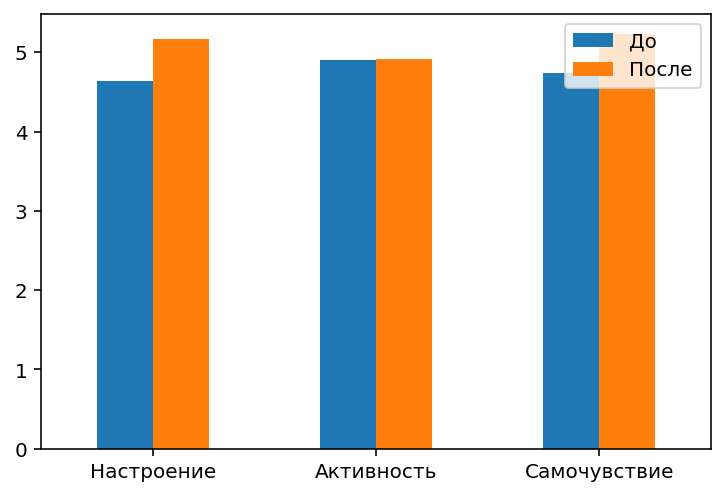

In [51]:
before = [4.637500, 4.9, 4.7375]
after = [5.1625, 4.9125, 5.225]
index = ['Настроение', 'Активность', 'Самочувствие']
df_san = pd.DataFrame({'До': before,
                   'После': after}, index=index)
ax = df_san.plot.bar(rot=0)

In [52]:
sit_next.describe()

,Ваш возраст,Какой у вас стаж работы вахтой?,СТ до ТДТ,СТ после ТДТ,ЛТ до ТДТ,ЛТ после ТДТ
count,8.000000,8.000000,8.0000,8.000000,8.000000,8.000000
mean,38.625000,2.875000,32.5000,28.625000,44.750000,41.750000
std,9.425459,2.416461,14.0102,11.500776,13.090345,13.956565
min,27.000000,0.000000,18.0000,15.000000,27.000000,26.000000
25%,31.250000,1.750000,20.5000,19.000000,36.750000,29.250000
50%,38.500000,2.500000,33.0000,28.500000,42.500000,41.000000
75%,43.250000,3.250000,38.0000,33.750000,54.000000,52.250000
max,55.000000,8.000000,60.0000,50.000000,67.000000,64.000000


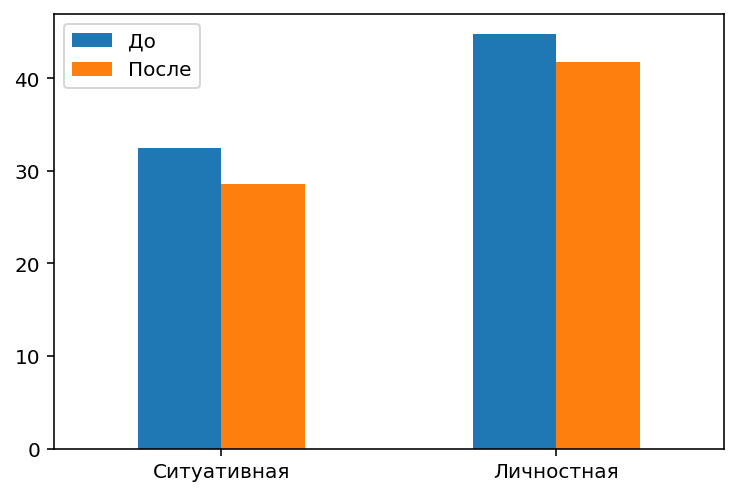

In [53]:
before = [32.5, 44.75]
after = [28.625, 41.75]
index = ['Ситуативная', 'Личностная']
df_trev = pd.DataFrame({'До': before,
                   'После': after}, index=index)
ax = df_trev.plot.bar(rot=0)

### Кластеризация пользователей, построение дендограммы

In [54]:
dendro = pd.read_csv(r'C:\Users\Иванов\Express_Grp1.csv', sep=';')

In [55]:
dendro

,Понятии,1,2,3,4,5,6,7,8
0,1 - Успех,0.43,0.29,0.29,0.00,0.00,0.00,0.00,0.00
1,2 - НЕУДАЧА,0.00,0.00,0.00,0.00,0.14,0.14,0.43,0.29
2,3 - Климат Якутии,0.29,0.14,0.14,0.29,0.00,0.14,0.00,0.00
3,4 - РАЗДРАЖЕНИЕ,0.00,0.00,0.00,0.29,0.00,0.43,0.00,0.29
4,5 - МОЕ САМОЧУВСТВИЕ,0.00,0.29,0.29,0.00,0.14,0.14,0.00,0.14
5,6 - РАДОСТЬ,0.57,0.29,0.14,0.00,0.00,0.00,0.00,0.00
6,7 - Мое участие в ТД тренинге,0.29,0.00,0.29,0.14,0.29,0.00,0.00,0.00
7,8 - УГРОЗА,0.00,0.00,0.00,0.14,0.29,0.00,0.29,0.29
8,9 - Дикая природа Якутии,0.14,0.43,0.14,0.29,0.00,0.00,0.00,0.00
9,10 - Мое рабочее место,0.29,0.14,0.00,0.14,0.00,0.00,0.14,0.29


In [56]:
scaler = StandardScaler()
x_sc = scaler.fit_transform(dendro.drop(columns = ['Понятии'], axis=1))

In [57]:
linked = linkage(x_sc, method = 'ward')

In [58]:
my_list = dendro['Понятии'].tolist()

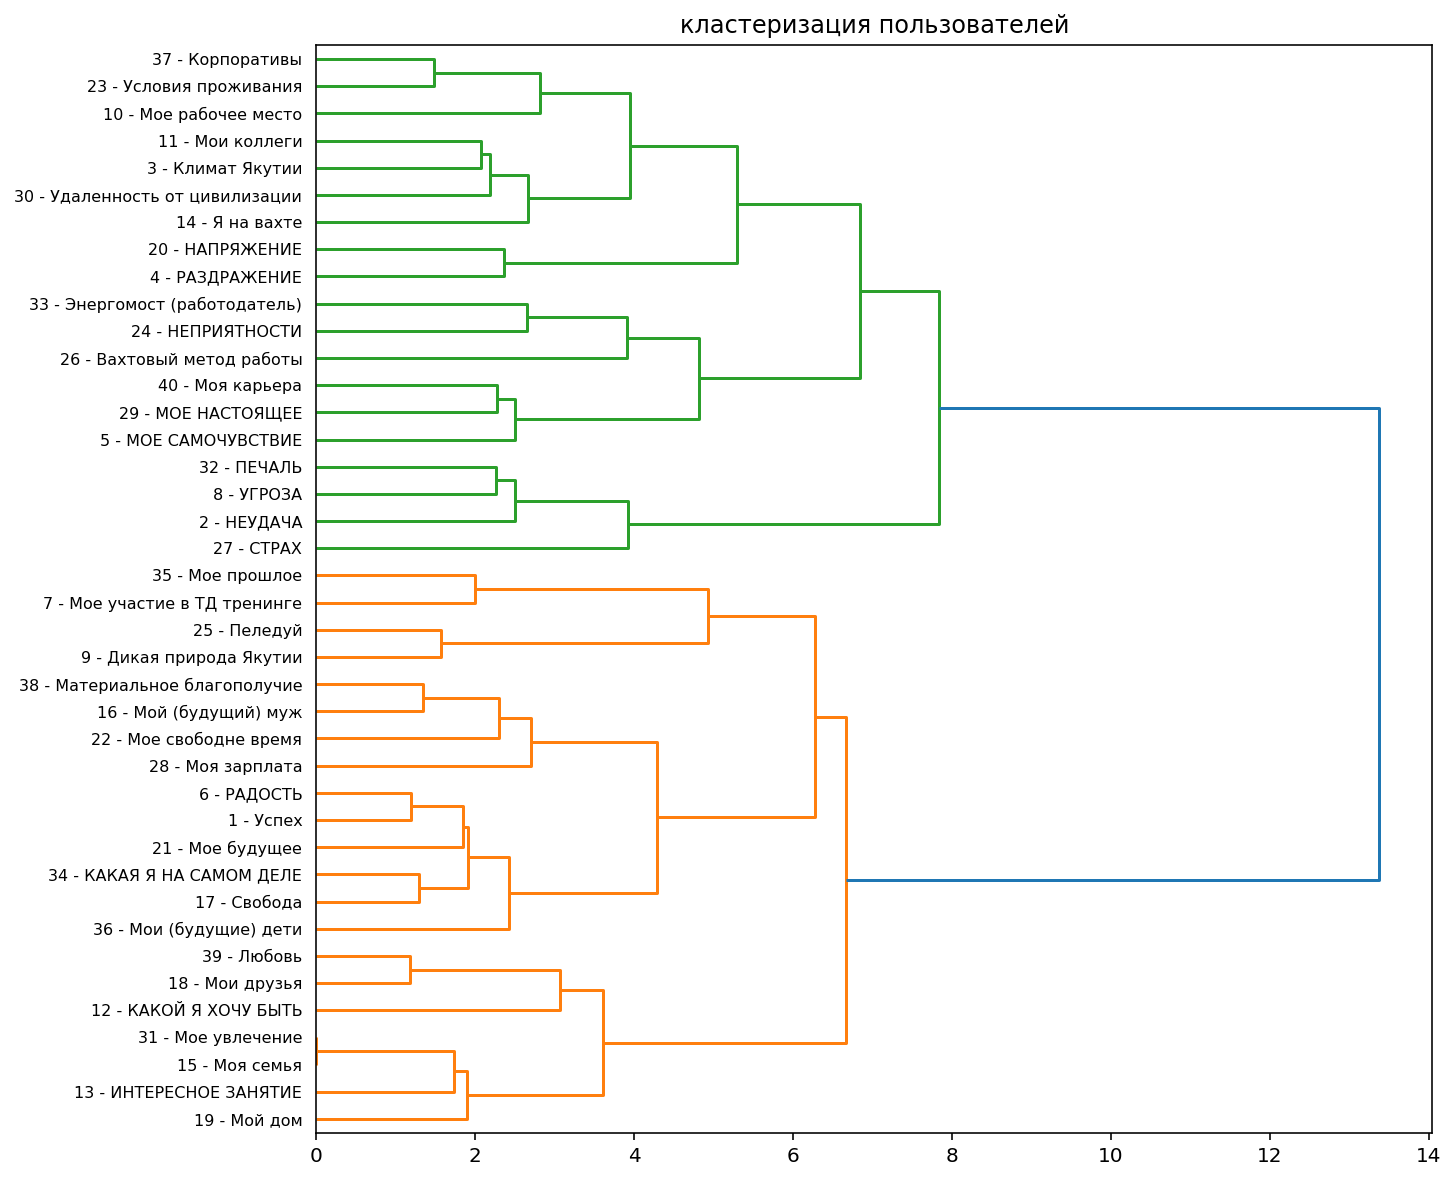

In [59]:
plt.figure(figsize=(10, 10))
dendrogram(linked, orientation = 'right', labels=my_list)
plt.title('кластеризация пользователей')
plt.show()